# Feedback Prize EDA & BERT Baseline

## Libraries & Utilities

In [1]:
import os
import gc
import itertools
import pandas as pd
import numpy as np
from tqdm import tqdm
from nltk import tokenize
from collections import Counter
from nltk.corpus import stopwords
from sklearn.metrics import (accuracy_score,
                             f1_score,
                             recall_score,
                             confusion_matrix)

# PyTorch
import torch
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
import torch.nn.functional as F
import torch.nn as nn

# BERT
from transformers import BertTokenizer, BertModel
import transformers
transformers.logging.set_verbosity_error()

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
%matplotlib inline
sns.set_style('whitegrid')
sns.set_context("notebook", font_scale=0.9, rc={"lines.linewidth": 1.8})

## 📃 Variable Description


- **discourse_id** - ID code for discourse element
- **essay_id** - ID code for essay response. This ID code corresponds to the name of the full-text file in the train/ folder.
- **discourse_text** - Text of discourse element.
- **discourse_type** - Class label of discourse element.
- **discourse_effectiveness** - Quality rating of discourse element, the target.,

---

## Loading Data

In [2]:
input_dir = "/kaggle/input/feedback-prize-effectiveness"
train_dir = os.path.join(input_dir, "train")
train_csv = os.path.join(input_dir, "train.csv")
test_dir = os.path.join(input_dir, "test")
test_csv = os.path.join(input_dir, "test.csv")
submission_csv = os.path.join(input_dir, 'sample_submission.csv')

train = pd.read_csv(train_csv)
test = pd.read_csv(test_csv)
submission = pd.read_csv(submission_csv)

print(f'Train Shape: {train.shape}')
print(f'Test Shape: {test.shape}')
train.head()

Train Shape: (36765, 5)
Test Shape: (10, 4)


,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate


In [3]:
train.describe().T

,count,unique,top,freq
discourse_id,36765,36765,0013cc385424,1
essay_id,36765,4191,91B1F82B2CF1,23
discourse_text,36765,36691,Summer projects should be student-designed,14
discourse_type,36765,7,Evidence,12105
discourse_effectiveness,36765,3,Adequate,20977


## Discourse Types & Effectiveness

The dataset presented here contains argumentative essays written by U.S students in grades 6-12. These essays were annotated by expert raters for discourse elements commonly found in argumentative writing:

- **Lead** - an introduction that begins with a statistic, a quotation, a description, or some other device to grab the reader’s attention and point toward the thesis
- **Position** - an opinion or conclusion on the main question
- **Claim** - a claim that supports the position
- **Counterclaim** - a claim that refutes another claim or gives an opposing reason to the position
- **Rebuttal** - a claim that refutes a counterclaim
- **Evidence** - ideas or examples that support claims, counterclaims, or rebuttals.
- **Concluding** Statement - a concluding statement that restates the claims

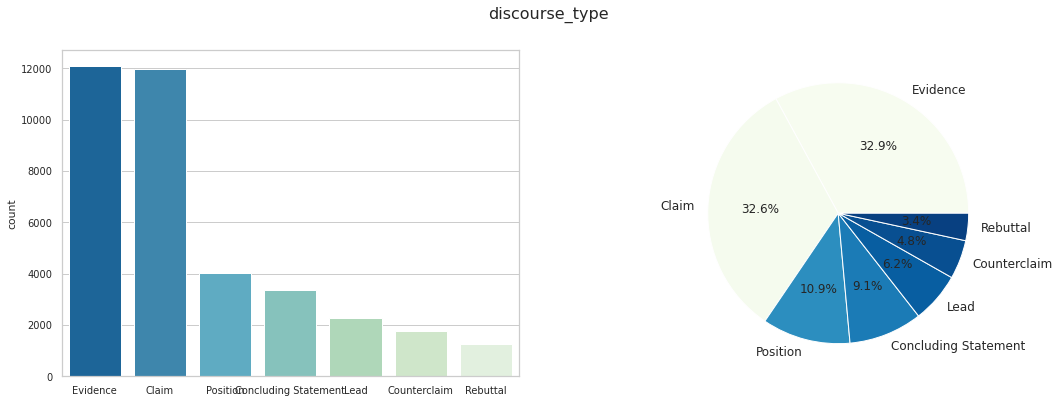

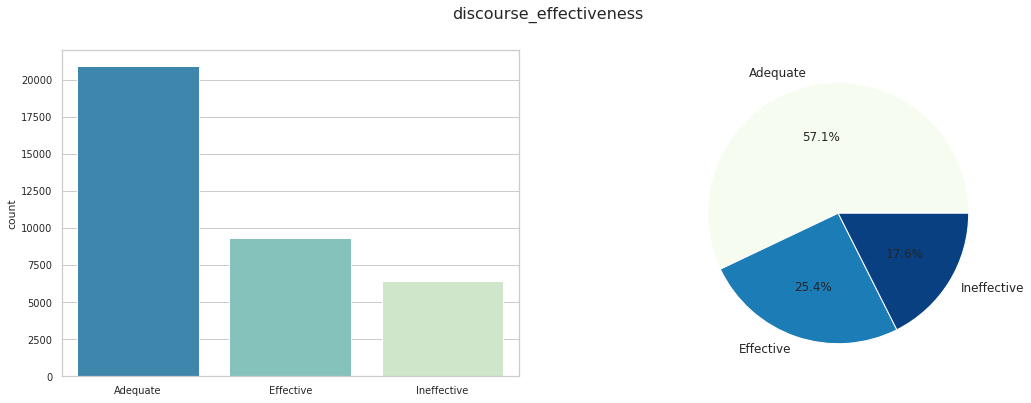

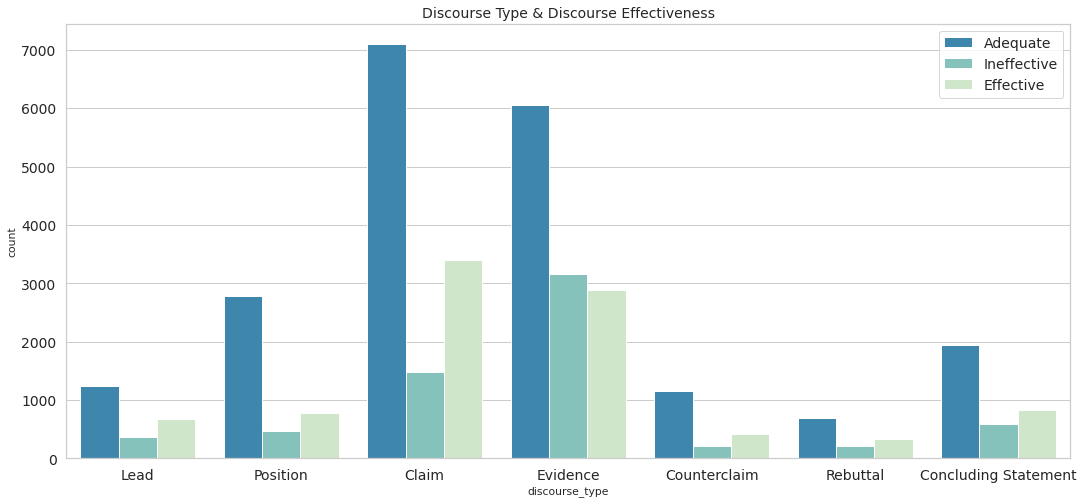

In [4]:
def cat_analyser(data, col):
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18, 6))
    fig.suptitle(col, fontsize = 16)
    sns.countplot(data = data,
                  x = col,
                  ax = ax[0],
                  palette= 'GnBu_r',
                  order =  data[col].value_counts().index)
    ax[0].set_xlabel('')
    pie_cmap = plt.get_cmap('GnBu_r')
    normalize = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)) 
    data[col].value_counts().plot.pie(autopct='%1.1f%%',
                                      textprops={'fontsize': 12},
                                      ax=ax[1],
                                      colors = pie_cmap(normalize(data[col].value_counts())))
    ax[1].set_ylabel('')
    plt.show()
    
for col in ['discourse_type', 'discourse_effectiveness']:
    cat_analyser(train, col)
    
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(18, 8))
sns.countplot(data = train,
              x = 'discourse_type',
              hue ='discourse_effectiveness',
              palette = 'GnBu_r')
plt.legend(loc = 'best', prop={'size': 14})
plt.title('Discourse Type & Discourse Effectiveness', size = 14)
plt.yticks(size = 14)
plt.xticks(size = 14)
plt.show()

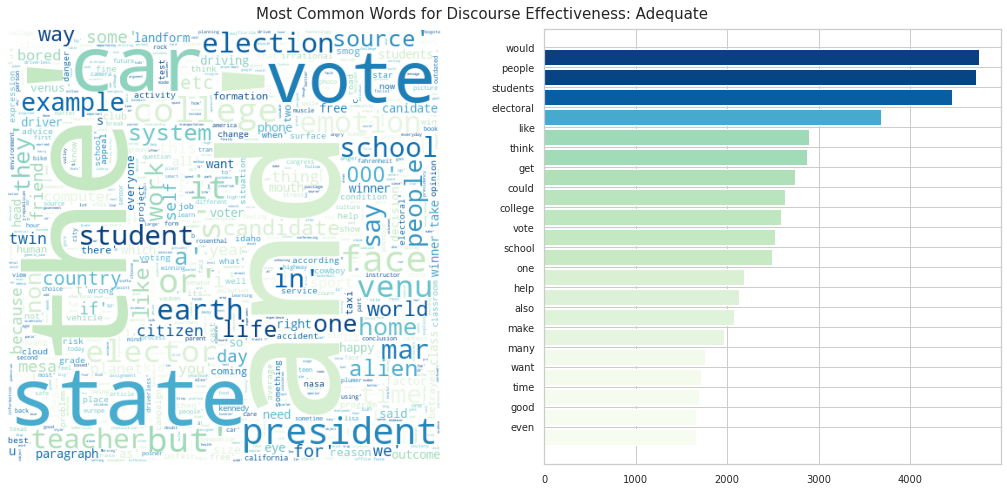

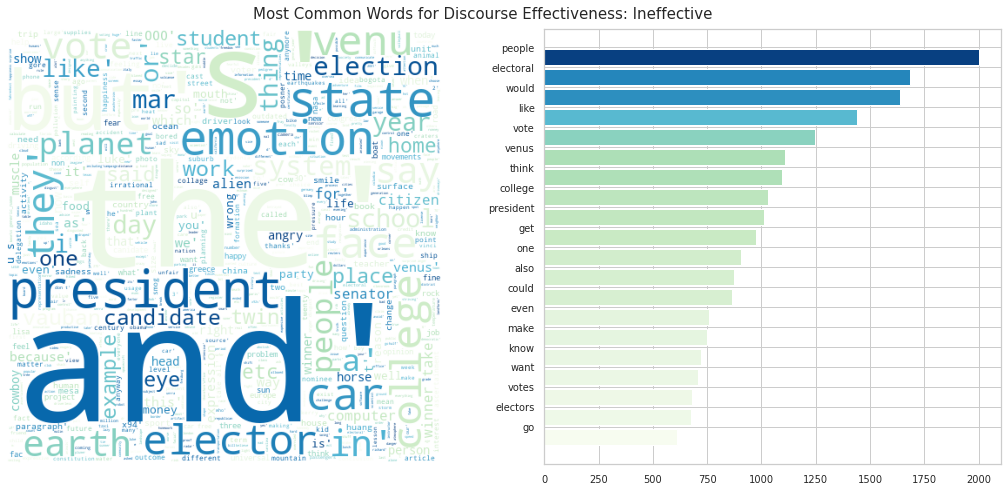

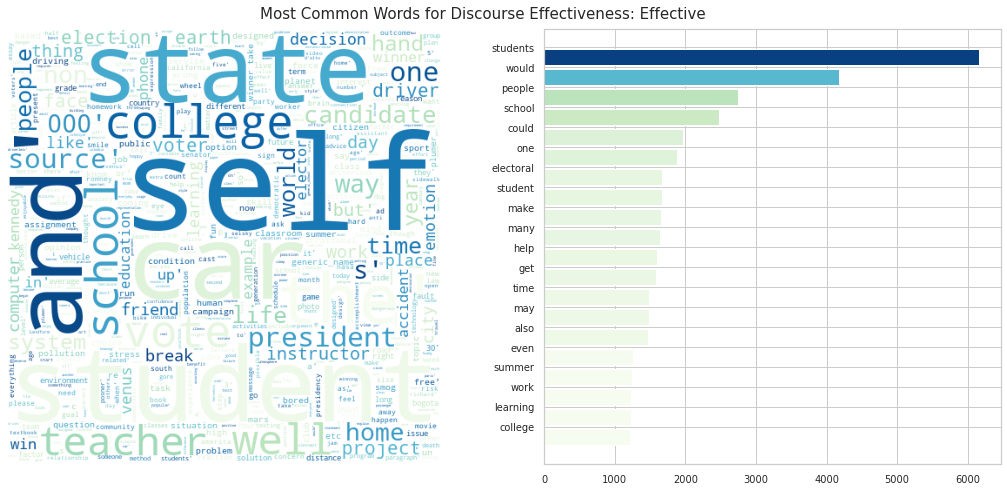

In [5]:
def CommonWords(data, col, numWords, title, bar_limit = 20):
    
    topic_words = [z.lower() for y in [x.split() for x in data[col] 
                                       if isinstance(x, str)] for z in y]
    word_count_dict = dict(Counter(topic_words))
    popular_words = sorted(word_count_dict, key = word_count_dict.get, reverse = True)
    popular_words_nonstop = [word for word in popular_words if word not in stopwords.words("english")]
    word_string=str(popular_words_nonstop)
    wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white',
                          max_words=numWords,
                          width= 500,
                          height= 500,
                          colormap = 'GnBu_r'
                         ).generate(word_string)
    
    fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols= 2, figsize = (18, 8))
    fig.suptitle(title, fontsize=15, y = 0.92)
    ax1.imshow(wordcloud)
    ax1.axis('off')
    
    bar_cmap = plt.get_cmap("GnBu")
    reversed_popular_words_nonstop = [word_count_dict[w] for w in reversed(popular_words_nonstop[0:bar_limit])]
    normalize = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x))
    ax2.barh(range(bar_limit), [word_count_dict[w] for w in reversed(popular_words_nonstop[0:bar_limit])],
             color=bar_cmap(normalize(reversed_popular_words_nonstop)))
    ax2.set_yticks([x + 0.5 for x in range(bar_limit)], reversed(popular_words_nonstop[0:bar_limit]))
    plt.show()

for dis_eff in train['discourse_effectiveness'].unique():
    sub_df = train.loc[train['discourse_effectiveness'] == dis_eff]
    title = f'Most Common Words for Discourse Effectiveness: {dis_eff}'
    CommonWords(sub_df,'discourse_text',1000, title)

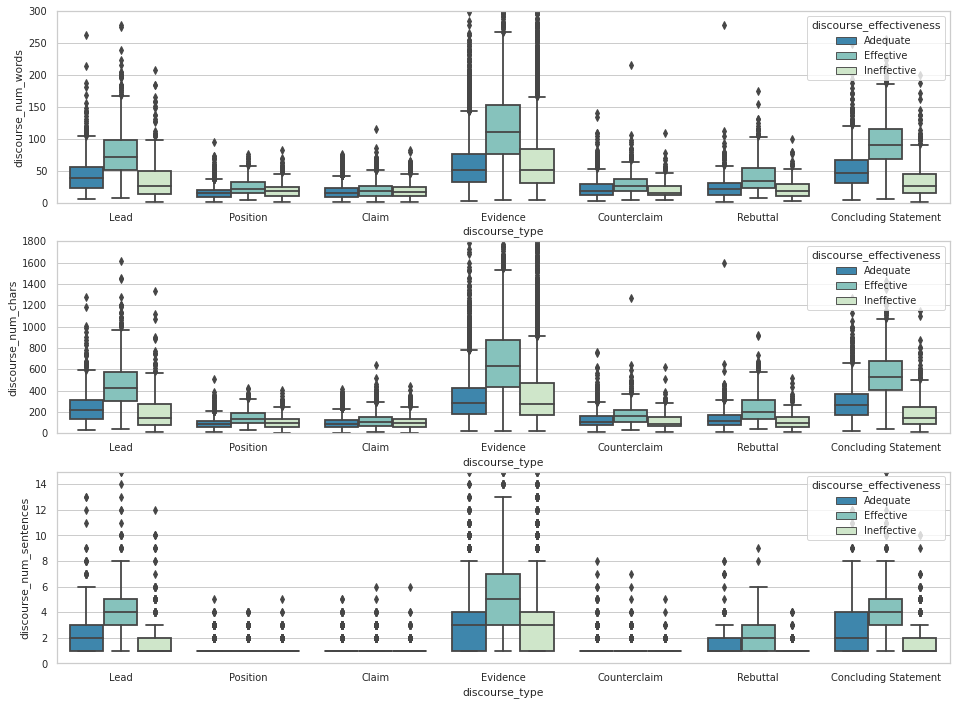

In [6]:
def WordCounts(dataframe):
    df_ = dataframe.copy()
    df_["discourse_num_chars"] = df_['discourse_text'].apply(lambda x: len(x))
    df_["discourse_num_words"] = df_['discourse_text'].apply(lambda x: len(x.split()))
    df_["discourse_num_sentences"] = df_['discourse_text'].apply(lambda x: len(tokenize.sent_tokenize(x)))
    fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize = (16, 12))
    sns.boxplot(data = df_, 
                y = 'discourse_num_words', 
                x='discourse_type', 
                hue='discourse_effectiveness', 
                hue_order = df_['discourse_effectiveness'].value_counts().index, 
                palette = 'GnBu_r',
                ax=ax[0])
    ax[0].set_ylim([0,300])

    sns.boxplot(data = df_,
                y = 'discourse_num_chars', 
                x='discourse_type', 
                hue='discourse_effectiveness', 
                hue_order = df_['discourse_effectiveness'].value_counts().index, 
                palette = 'GnBu_r',
                ax=ax[1])
    ax[1].set_ylim([0,1800])

    sns.boxplot(data = df_,
                y = 'discourse_num_sentences', 
                x = 'discourse_type', 
                hue = 'discourse_effectiveness', 
                hue_order = df_['discourse_effectiveness'].value_counts().index, 
                palette = 'GnBu_r',
                ax = ax[2])
    ax[2].set_ylim([0,15])
    plt.show()
    
WordCounts(train)

## Defining Feedback Dataset

In [7]:
target_list = submission.columns[1:].tolist()
for col in target_list:
    train[col] = np.where(train['discourse_effectiveness'] == col, 1, 0)

class config:
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased', return_dict = True)
    train_size = 0.8
    train_batch_size = 64
    val_batch_size = 64
    max_len = 128
    epochs = 1

class FeedbackPrizeDataset(Dataset):
    def __init__(self, data, max_len, tokenizer, data_path):
        self.data = data
        self.max_len = max_len
        self.tokenizer = tokenizer
        self.data_path = data_path
        self.discourse_text = data['discourse_text'].values
        self.discourse_type = data['discourse_type'].values
        self.targets = data[target_list].values
        self.essay_id = data['essay_id'].values
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        discourse_text = self.discourse_text[index]
        discourse_type = self.discourse_type[index]
        essay_path = os.path.join(self.data_path, f"{self.essay_id[index]}.txt")
        essay = open(essay_path, 'r').read()
        text = ' '.join([discourse_type,
                         self.tokenizer.sep_token,
                         discourse_text,
                         self.tokenizer.sep_token,
                         essay])
        
        inputs = self.tokenizer.encode_plus(text.lower(),
                                            truncation=True,
                                            padding = 'max_length',
                                            add_special_tokens=True,
                                            return_attention_mask = True,
                                            return_token_type_ids= True,
                                            max_length=self.max_len,
                                            return_tensors = 'pt')
        input_ids = inputs['input_ids'].flatten()
        attention_mask = inputs['attention_mask'].flatten()
        token_type_ids = inputs['token_type_ids'].flatten()
        targets = torch.FloatTensor(self.targets[index])

        return {'input_ids': input_ids,
                'attention_mask': attention_mask,
                'token_type_ids': token_type_ids,
                'targets': targets}

## Creating Train-Validation Sets

In [8]:
train_df = train.sample(frac = config.train_size, random_state = 42).reset_index(drop = True)
val_df = train.drop(train_df.index).reset_index(drop = True)
print(f'Train: {train_df.shape}')
print(f'Validation: {val_df.shape} \n')

for col in target_list:
    print(col.center(60, '-'))
    print(train_df[col].value_counts())
    print(val_df[col].value_counts(), '\n')

Train: (29412, 8)
Validation: (7353, 8) 

------------------------Ineffective-------------------------
0    24247
1     5165
Name: Ineffective, dtype: int64
0    6478
1     875
Name: Ineffective, dtype: int64 

--------------------------Adequate--------------------------
1    16800
0    12612
Name: Adequate, dtype: int64
1    3769
0    3584
Name: Adequate, dtype: int64 

-------------------------Effective--------------------------
0    21965
1     7447
Name: Effective, dtype: int64
0    4644
1    2709
Name: Effective, dtype: int64 



In [9]:
train_dataset = FeedbackPrizeDataset(train_df,
                                     max_len = config.max_len,
                                     tokenizer = config.tokenizer,
                                     data_path = train_dir)

valid_dataset = FeedbackPrizeDataset(val_df,
                                     max_len = config.max_len,
                                     tokenizer = config.tokenizer,
                                     data_path = train_dir)

train_data_loader = DataLoader(train_dataset,
                               shuffle = True,
                               batch_size = config.train_batch_size,
                               num_workers = 2)

val_data_loader = DataLoader(valid_dataset,
                             shuffle = False,
                             batch_size = config.val_batch_size,
                             num_workers = 2)

## Building Model

In [10]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [11]:
class FeedbackPrizeModel(torch.nn.Module):
    def __init__(self):
        super(FeedbackPrizeModel, self).__init__()
        self.bert_model = config.model
        self.dropout = torch.nn.Dropout(0.3)
        self.linear = torch.nn.Linear(768, len(target_list))
    
    def forward(self, input_ids, attention_mask, token_type_ids):
        output = self.bert_model(input_ids, 
                                 attention_mask = attention_mask, 
                                 token_type_ids = token_type_ids)
        output = self.dropout(output.pooler_output)
        output = self.linear(output)
        
        return output

model = FeedbackPrizeModel()
model.to(device)

FeedbackPrizeModel(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [12]:
#Loss Function
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

#Adjust Learning Rate
def adjust_lr(optimizer, epoch):
    if epoch < 1:
        lr = 5e-5
    elif epoch < 2:
        lr = 1e-3
    elif epoch < 5:
        lr = 1e-4
    else:
        lr = 1e-5
    for param in optimizer.param_groups:
        param['lr'] = lr
    
#Optimizer
def get_optimizer(net):
    optimizer = torch.optim.Adam(filter(lambda x: x.requires_grad, net.parameters()),
                                 betas = (0.9, 0.999),
                                 weight_decay = 0.003, #regularization
                                 eps = 1e-08)
    return optimizer

## Train Model

In [13]:
val_targets=[]
val_outputs=[]

def train_model(n_epochs,
                train_loader,
                val_loader,
                model):
    
    optimizer = get_optimizer(model)
    for epoch in range(n_epochs):
        train_loss = 0
        val_loss = 0     
        model.train()
        adjust_lr(optimizer, epoch)
        print(f' Epoch: {epoch + 1} - Train Set '.center(50, '='))
        for batch_idx, batch in enumerate(tqdm(train_loader)):
            input_ids = batch['input_ids'].to(device, dtype = torch.long)
            attention_mask = batch['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = batch['token_type_ids'].to(device, dtype = torch.long)
            targets = batch['targets'].to(device, dtype = torch.float)
            outputs = model(input_ids, attention_mask, token_type_ids)
            
            optimizer.zero_grad()
            loss = loss_fn(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.item() - train_loss))
            del input_ids, attention_mask, token_type_ids, targets, outputs
            gc.collect()
    
        print(f' Epoch: {epoch + 1} - Validation Set '.center(50, '='))
        model.eval()
        with torch.no_grad():
            for batch_idx, data in enumerate(tqdm(val_loader)):
                input_ids = data['input_ids'].to(device, dtype = torch.long)
                attention_mask = data['attention_mask'].to(device, dtype = torch.long)
                token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
                targets = data['targets'].to(device, dtype = torch.float)
                outputs = model(input_ids, attention_mask, token_type_ids)
                
                loss = loss_fn(outputs, targets)
                val_loss = val_loss + ((1 / (batch_idx + 1)) * (loss.item() - val_loss))
                val_targets.extend(targets.cpu().detach().numpy().tolist())
                val_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
                del input_ids, attention_mask, token_type_ids, targets, outputs
                gc.collect()
            train_loss = train_loss/len(train_loader)
            val_loss = val_loss/len(val_loader)
            print('Epoch: {} \tAvgerage Training Loss: {:.6f} \tAverage Validation Loss: {:.6f} \n'.format(
            epoch + 1, 
            train_loss,
            val_loss
            ))
                
    return model                    

In [14]:
model = train_model(n_epochs = config.epochs,
                    train_loader = train_data_loader,
                    val_loader = val_data_loader,
                    model = model)

============== Epoch: 1 - Train Set ==============


100%|██████████| 460/460 [10:23<00:00,  1.35s/it]


=========== Epoch: 1 - Validation Set ============


100%|██████████| 115/115 [02:32<00:00,  1.32s/it]

Epoch: 1 	Avgerage Training Loss: 0.001052 	Average Validation Loss: 0.003694 



Accuracy Score: 0.7007
Recall (Micro): 0.7007
Recall (Macro): 0.5246
F1 Score (Micro): 0.7007
F1 Score (Macro): 0.5079 



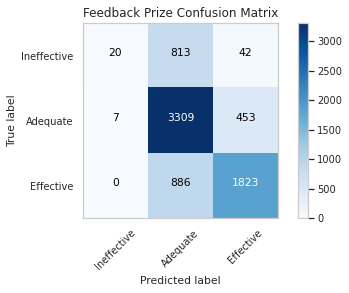

In [15]:
val_outputs_labels = np.array([np.argmax(a) for a in val_outputs])
val_targets_labels = np.array([np.argmax(a) for a in val_targets])
accuracy = accuracy_score(val_targets_labels, val_outputs_labels)
recall_micro = recall_score(val_targets_labels, val_outputs_labels, average = 'micro')
recall_macro = recall_score(val_targets_labels, val_outputs_labels, average = 'macro')
f1_score_micro = f1_score(val_targets_labels, val_outputs_labels, average='micro')
f1_score_macro = f1_score(val_targets_labels, val_outputs_labels, average='macro')
print(f"Accuracy Score: {round(accuracy, 4)}")
print(f"Recall (Micro): {round(recall_micro, 4)}")
print(f"Recall (Macro): {round(recall_macro, 4)}")
print(f"F1 Score (Micro): {round(f1_score_micro, 4)}")
print(f"F1 Score (Macro): {round(f1_score_macro, 4)} \n")
cm = confusion_matrix(val_targets_labels, val_outputs_labels)

def plot_confusion_matrix(cm,
                          classes,
                          title):

    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title(title, size = 12)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.0f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)
    plt.show()
    
plot_confusion_matrix(cm,
                      target_list,
                      title='Feedback Prize Confusion Matrix')

In [16]:
class FeedbackPrizeTestDataset(Dataset):
    def __init__(self, data, max_len, tokenizer, data_path):
        self.data = data
        self.max_len = max_len
        self.tokenizer = tokenizer
        self.data_path = data_path
        self.discourse_text = data['discourse_text'].values
        self.discourse_type = data['discourse_type'].values
        self.essay_id = data['essay_id'].values
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        discourse_text = self.discourse_text[index]
        discourse_type = self.discourse_type[index]
        essay_path = os.path.join(self.data_path, f"{self.essay_id[index]}.txt")
        essay = open(essay_path, 'r').read()
        text = ' '.join([discourse_type,
                         self.tokenizer.sep_token,
                         discourse_text,
                         self.tokenizer.sep_token,
                         essay])
        
        inputs = self.tokenizer.encode_plus(text.lower(),
                                            truncation=True,
                                            padding = 'max_length',
                                            add_special_tokens=True,
                                            return_attention_mask = True,
                                            return_token_type_ids= True,
                                            max_length=self.max_len,
                                            return_tensors = 'pt')
        input_ids = inputs['input_ids'].flatten()
        attention_mask = inputs['attention_mask'].flatten()
        token_type_ids = inputs['token_type_ids'].flatten()

        return {'input_ids': input_ids,
                'attention_mask': attention_mask,
                'token_type_ids': token_type_ids}
    
    
test_dataset = FeedbackPrizeTestDataset(test,
                                        max_len = config.max_len,
                                        tokenizer = config.tokenizer,
                                        data_path = test_dir)

test_data_loader = DataLoader(test_dataset,
                              shuffle = True,
                              batch_size = config.train_batch_size,
                              num_workers = 2)

In [17]:
def test_model(model, test_loader):
    model.eval()
    preds = []
    with torch.no_grad():
        for batch_idx, data in enumerate(tqdm(test_loader)):
            input_ids = data['input_ids'].to(device, dtype = torch.long)
            attention_mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            outputs = model(input_ids, attention_mask, token_type_ids)
            preds.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return preds

y_pred = test_model(model, test_data_loader)
pred_data = pd.DataFrame({col: [col[idx] for col in y_pred]
                          for idx,col in enumerate(target_list)})
for col in submission.columns[1:]:
    submission[col] = pred_data[col]
submission

100%|██████████| 1/1 [00:00<00:00,  2.83it/s]


,discourse_id,Ineffective,Adequate,Effective
0,a261b6e14276,0.053611,0.511565,0.392365
1,5a88900e7dc1,0.022032,0.385408,0.577368
2,9790d835736b,0.031916,0.487022,0.450315
3,75ce6d68b67b,0.077766,0.509725,0.332941
4,93578d946723,0.074891,0.484989,0.384946
5,2e214524dbe3,0.029404,0.462106,0.489573
6,84812fc2ab9f,0.042347,0.591410,0.343541
7,c668ff840720,0.067626,0.457980,0.409747
8,739a6d00f44a,0.022831,0.395404,0.565542
9,bcfae2c9a244,0.052159,0.575105,0.332936


In [18]:
#submission.to_csv('fbprize_sub.csv', index = False)